In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import json
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import warnings
warnings.filterwarnings('ignore')
import os
import seaborn as sns
import random
import os
import pickle
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from sklearn import metrics
import os

================================================================================================================

<H1>AR Features</H1>

================================================================================================================


Under this Experiment, we analyze the effect of AR orders on the performance of our authentication systems across all the datasets. We tested the AR orders from 1 to 10. Below Parameters were applied for conducting this experiment

<H3>Datasets</H3>

BrainInvaders15a, ERPCORE: N400, ERPCORE: N400, Mantegna2019, COG-BCI Flanker, Lee2019, Won2022,     Huebner2017, Sosulski2019

<H3>Utilized Parameters:</H3>

•   Filtering: Band Pass Filtering (1 to 50 Hz)

•   Epoch Interval: [-0.2, 0.8] 

•   Baseline Correction Applied: Yes

•   Epochs Rejection threshold: No Epochs Rejection

•   Features: AR (order=1,2,3,4,5,6,7,8,9,10)

•   Classifiers: LDA, SVM, KNN, RF, NB, LR

•   Evaluation Type: Single-Session Evaluation

•   Threat Case: Open-Set

In [2]:
main_dir=os.path.dirname(os.getcwd())
results_dir=os.path.join(main_dir, "Results")
brainInvaders_dir=os.path.join(results_dir, "BrainInvaders15a", 'Experiments')
COG_BCI_Flanker_dir=os.path.join(results_dir, "COG_BCI_Flanker", 'Experiments')
ERPCORE_N400_dir=os.path.join(results_dir, "ERPCORE_N400", 'Experiments')
ERPCORE_P300_dir=os.path.join(results_dir, "ERPCORE_P300", 'Experiments')
Huebner_LLP_dir=os.path.join(results_dir, "Huebner_LLP", 'Experiments')
Mantegna2019_dir=os.path.join(results_dir, "Mantegna2019", 'Experiments')
Sosulski2019_dir=os.path.join(results_dir, "Sosulski2019", 'Experiments')
Won2022_dir=os.path.join(results_dir, "Won2022", 'Experiments')

### Reading data files 

In [3]:
brain_AR_db=pd.read_csv(os.path.join(brainInvaders_dir, "Only_AR_Features", 'AR_Order.csv'))
erpCore_N400_AR_db=pd.read_csv(os.path.join(ERPCORE_N400_dir, "Only_AR_Features", 'AR_Order.csv'))
erpCore_P300_AR_db=pd.read_csv(os.path.join(ERPCORE_P300_dir, "Only_AR_Features", 'AR_Order.csv'))
cogbci_AR_db=pd.read_csv(os.path.join(COG_BCI_Flanker_dir, "Only_AR_Features", 'AR_Order.csv'))
manetgna_AR_db=pd.read_csv(os.path.join(Mantegna2019_dir, "Only_AR_Features", 'AR_Order.csv'))
Huebner_AR_db=pd.read_csv(os.path.join(Huebner_LLP_dir, "Only_AR_Features", 'AR_Order.csv'))
sosulski_AR_db=pd.read_csv(os.path.join(Sosulski2019_dir, "Only_AR_Features", 'AR_Order.csv'))
Won2022_AR_db=pd.read_csv(os.path.join(Won2022_dir, "Only_AR_Features", 'AR_Order.csv'))
#erpCore_N400_AR_db=pd.read_csv(os.path.join(ERPCORE_N400_dir, "Only_AR_Features", 'AR_Order.csv'))

In [4]:
df_AR_features_db=pd.concat([brain_AR_db, erpCore_N400_AR_db,
                                    erpCore_P300_AR_db, cogbci_AR_db,
                                    manetgna_AR_db, Huebner_AR_db, sosulski_AR_db, Won2022_AR_db], axis=0)

In [5]:
df_AR_features_db

,Unnamed: 0,evaluation,eval Type,dataset,pipeline,subject,session,frr_1_far,frr_0.1_far,frr_0.01_far,eer,n_samples,AR_order
0,0,Single Session,Open Set,Brain Invaders 2015a,AR+SVM,1,session_1,0.000000,0.000000,0.000000,0.000010,11913,1
1,1,Single Session,Open Set,Brain Invaders 2015a,AR+SVM,2,session_1,0.007937,0.007937,0.011905,0.007942,11913,1
2,2,Single Session,Open Set,Brain Invaders 2015a,AR+SVM,3,session_1,0.000000,0.000000,0.000000,0.000010,11913,1
3,3,Single Session,Open Set,Brain Invaders 2015a,AR+SVM,4,session_1,0.000000,0.000000,0.000000,0.000010,11913,1
4,4,Single Session,Open Set,Brain Invaders 2015a,AR+SVM,5,session_1,0.000000,0.000000,0.000000,0.000010,11913,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,325,Single Session,Open Set,won 2022,AR+RF,51,session_1,0.774915,0.925000,0.975000,0.197795,11000,10
3296,326,Single Session,Open Set,won 2022,AR+RF,52,session_1,0.734999,0.878750,0.958700,0.144436,11000,10
3297,327,Single Session,Open Set,won 2022,AR+RF,53,session_1,0.734999,0.970500,0.990000,0.156830,11000,10
3298,328,Single Session,Open Set,won 2022,AR+RF,54,session_1,0.948333,0.995000,0.995000,0.333809,11000,10


In [6]:
df_AR_features_db.drop(columns=['evaluation', 'Unnamed: 0'], inplace=True)
df_AR_features_db['pipeline'] = df_AR_features_db['pipeline'].apply(lambda x: x.split('+')[-1])
df_AR_features_db['dataset'].replace({'Visual Speller LLP': "Huebner2017", 'Spot Pilot P300 dataset':'Sosulski2019'}, inplace=True)

In [7]:
df_AR_features_db.columns

Index(['eval Type', 'dataset', 'pipeline', 'subject', 'session', 'frr_1_far',
       'frr_0.1_far', 'frr_0.01_far', 'eer', 'n_samples', 'AR_order'],
      dtype='object')

### Grouping the results of AR Orders

In [8]:
grouped_df_AR=df_AR_features_db.groupby(['dataset','pipeline', 'AR_order']).agg({
                'eer': lambda x: f'{np.mean(x)*100:.2f}',
                #'frr_1_far': lambda x: f'{np.mean(x)*100:.3f}'
            }).reset_index()
#grouped_df_AR

In [9]:
grouped_df_AR.dataset.unique()

array(['Brain Invaders 2015a', 'COG-BCI Flanker', 'Huebner2017',
       'Sosulski2019', 'erpcore n400', 'erpcore p300', 'mantegna 2019',
       'won 2022'], dtype=object)

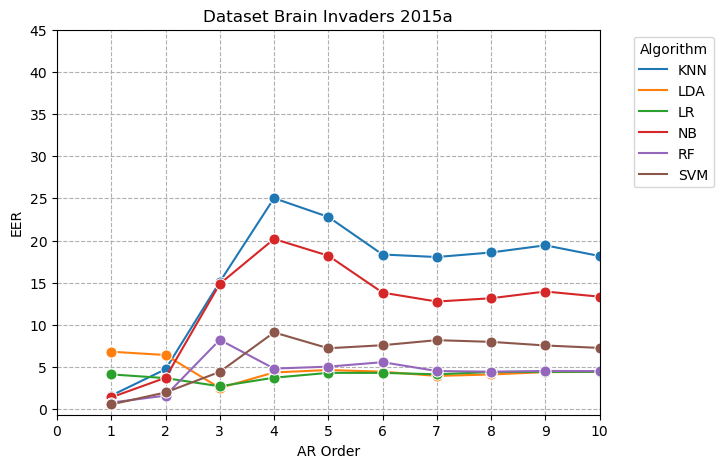

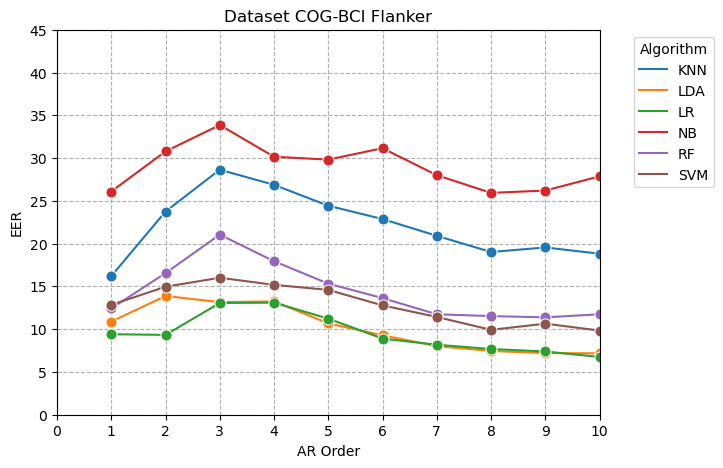

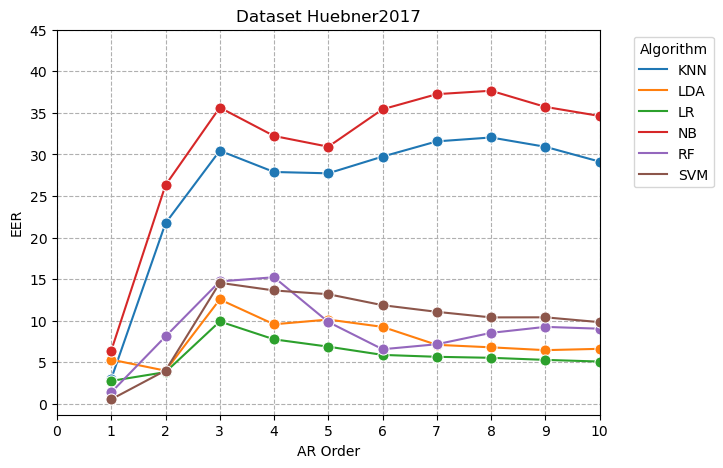

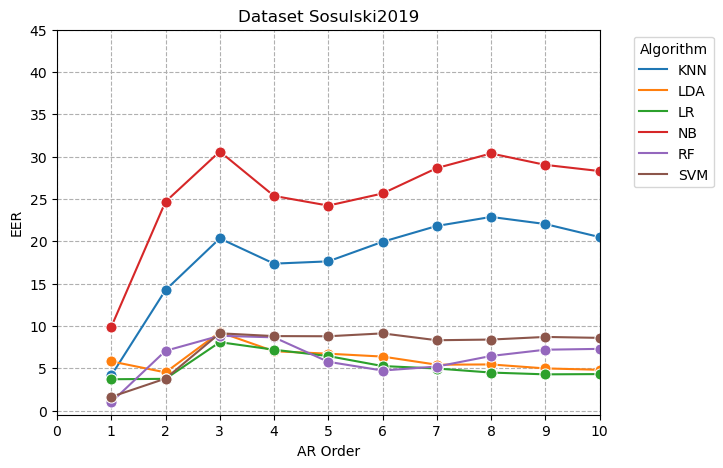

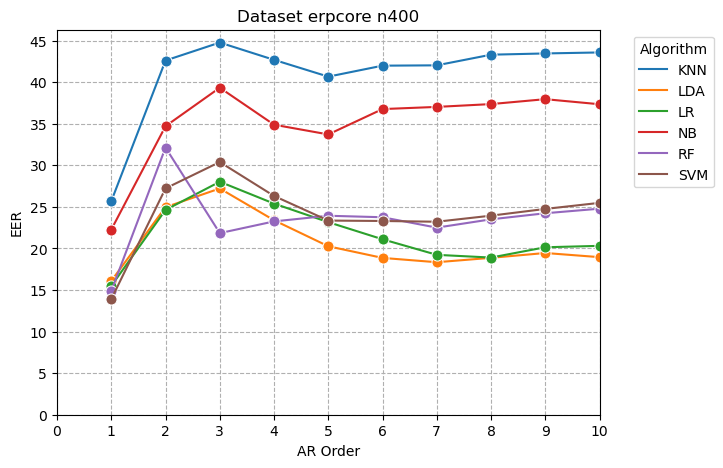

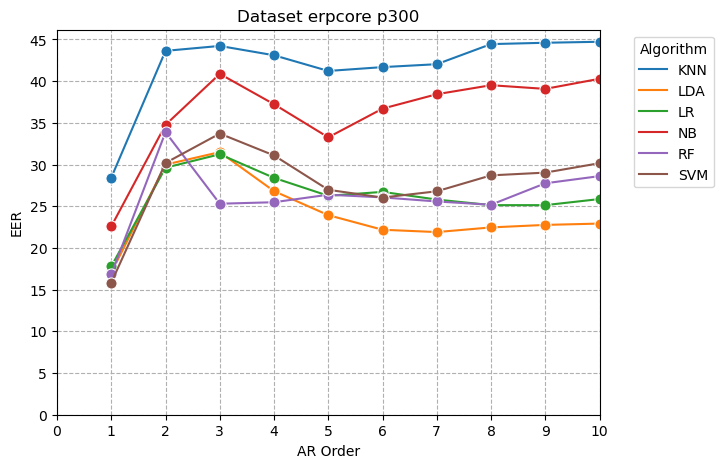

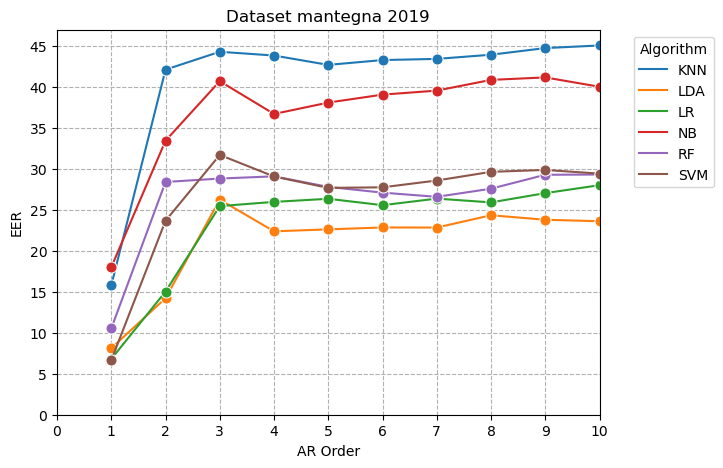

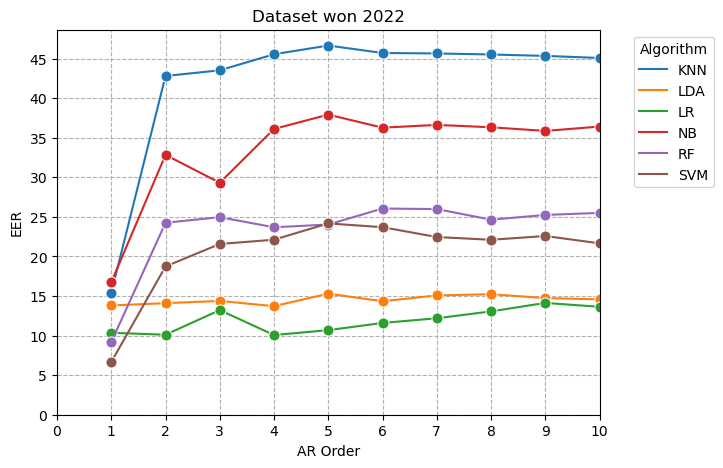

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

grouped_df_AR['eer'] = grouped_df_AR['eer'].astype('float64')

for dataset in grouped_df_AR.dataset.unique():
    
    db=grouped_df_AR[grouped_df_AR.dataset==dataset]
    plt.figure(figsize=(7, 5))
    sns.lineplot(x='AR_order', y='eer', hue='pipeline', data=db, marker='o', markersize=8)

    # Set labels and title
    plt.xlabel('AR Order')
    plt.ylabel('EER')
    plt.title("Dataset "+dataset)
    #plt.title('EER for Different Pipelines Across AR Orders')

    # Show legend
    plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlim(0, 10)
    plt.xticks(range(0, 11, 1))

    # Set y-axis ticks at intervals of 1
    plt.yticks(range(0, int(max(grouped_df_AR['eer'])) + 1, 5))

    plt.grid(True, ls="--", lw=0.8)
    #ax.yaxis.set_major_locator(plt.MultipleLocator(base=1))
    #plt.savefig('/pc2/users/a/avinashk/Thesis_feature_Plots/Feature_Extratcion/Mantegna/Mantegna_AR.pdf', format='pdf', bbox_inches='tight')
    # Show the plot
    plt.show()


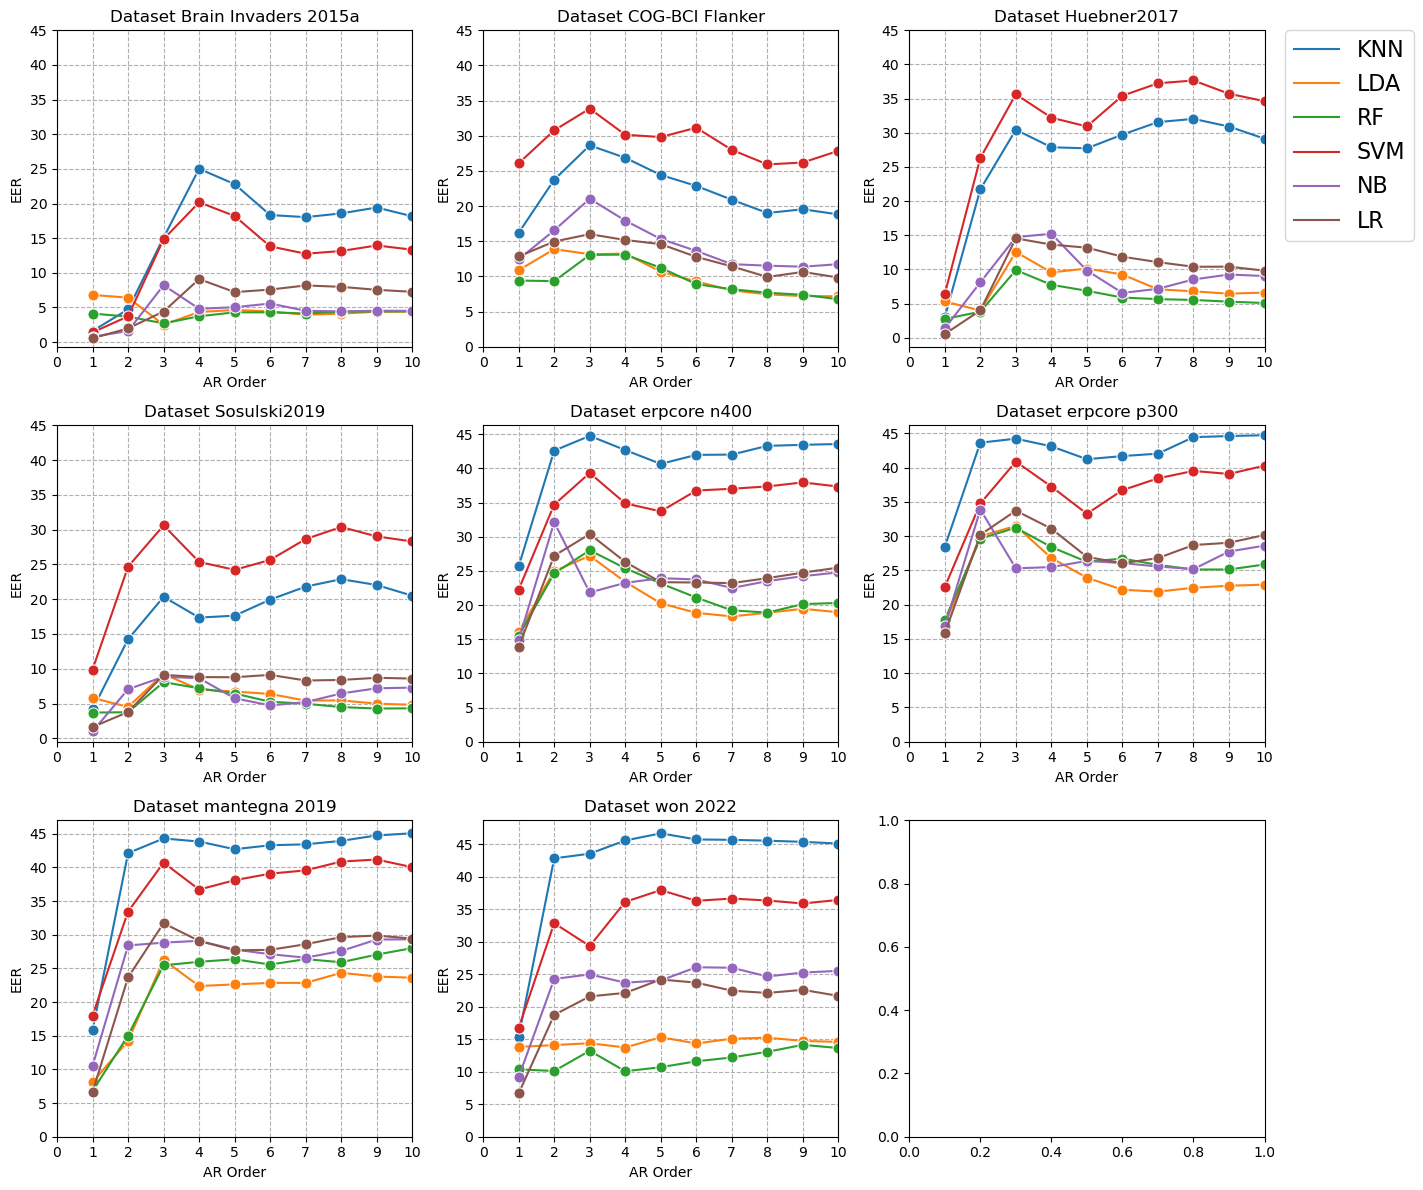

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

grouped_df_AR['eer'] = grouped_df_AR['eer'].astype('float64')

# Get unique datasets
datasets = grouped_df_AR.dataset.unique()

# Calculate number of rows and columns for subplots
rows = 3
columns = 3

# Create subplots
fig, axs = plt.subplots(rows, columns, figsize=(13, 12))

# Flatten the 2D array of subplots for easy iteration
axs = axs.flatten()

# Create an empty list to store legend handles and labels
legend_handles = []

for i, dataset in enumerate(datasets):
    db = grouped_df_AR[grouped_df_AR.dataset == dataset]

    # Choose the subplot for the current dataset
    ax = axs[i]

    sns.lineplot(x='AR_order', y='eer', hue='pipeline', data=db, marker='o', markersize=8, ax=ax)
    
    # Hide legend for each subplot
    ax.get_legend().remove()

    # Set labels and title
    ax.set_xlabel('AR Order')
    ax.set_ylabel('EER')
    ax.set_title("Dataset " + dataset)

    # Show legend for the last subplot
    if i == len(datasets) - 1:
        handles, labels = ax.get_legend_handles_labels()
        legend_handles.extend(handles)

    ax.set_xlim(0, 10)
    ax.set_xticks(range(0, 11, 1))

    # Set y-axis ticks at intervals of 1
    ax.set_yticks(range(0, int(max(grouped_df_AR['eer'])) + 1, 5))

    ax.grid(True, ls="--", lw=0.8)

# Create a legend outside the subplots
fig.legend(legend_handles, set(grouped_df_AR['pipeline']), loc='upper right', bbox_to_anchor=(1.10, 0.98), fontsize=12, prop={'size': 16})
plt.subplots_adjust(right=0.60)  # Adjust layout to make room for the legend

# Adjust layout
plt.tight_layout()
plt.show()


================================================================================================================

<H1>PSD Features</H1>

================================================================================================================


Under this Experiment, we analyze the effect of PSD Features on the performance of our authentication systems across all the datasets. We tested the PSD Features. Below Parameters were applied for conducting this experiment

<H3>Datasets</H3>

BrainInvaders15a, ERPCORE: N400, ERPCORE: N400, Mantegna2019, COG-BCI Flanker, Lee2019, Won2022,     Huebner2017, Sosulski2019

<H3>Utilized Parameters:</H3>

•   Filtering: Band Pass Filtering (1 to 50 Hz)

•   Epoch Interval: [-0.2, 0.8] 

•   Baseline Correction Applied: Yes

•   Epochs Rejection threshold: No Epochs Rejection

•   Features: PSD Features

•   Classifiers: LDA, SVM, KNN, RF, NB, LR

•   Evaluation Type: Single-Session Evaluation

•   Threat Case: Open-Set

### Reading data files

In [12]:
brain_PSD_db=pd.read_csv(os.path.join(brainInvaders_dir, "Only_PSD_Features", 'PSD_results.csv'))
erpCore_N400_PSD_db=pd.read_csv(os.path.join(ERPCORE_N400_dir, "Only_PSD_Features", 'PSD_results.csv'))
erpCore_P300_PSD_db=pd.read_csv(os.path.join(ERPCORE_P300_dir, "Only_PSD_Features", 'PSD_results.csv'))
cogbci_PSD_db=pd.read_csv(os.path.join(COG_BCI_Flanker_dir, "Only_PSD_Features", 'PSD_results.csv'))
manetgna_PSD_db=pd.read_csv(os.path.join(Mantegna2019_dir, "Only_PSD_Features", 'PSD_results.csv'))
Huebner_PSD_db=pd.read_csv(os.path.join(Huebner_LLP_dir, "Only_PSD_Features", 'PSD_results.csv'))
sosulski_PSD_db=pd.read_csv(os.path.join(Sosulski2019_dir, "Only_PSD_Features", 'PSD_results.csv'))
Won2022_PSD_db=pd.read_csv(os.path.join(Won2022_dir, "Only_PSD_Features", 'PSD_results.csv'))
#erpCore_N400_AR_db=pd.read_csv(os.path.join(ERPCORE_N400_dir, "Only_AR_Features", 'AR_Order.csv'))

In [13]:
df_PSD_features_db=pd.concat([brain_PSD_db, erpCore_N400_PSD_db,
                                    erpCore_P300_PSD_db, cogbci_PSD_db,
                                    manetgna_PSD_db, Huebner_PSD_db, sosulski_PSD_db, Won2022_PSD_db], axis=0)

In [14]:
df_PSD_features_db

,Unnamed: 0,evaluation,eval Type,dataset,pipeline,subject,session,frr_1_far,frr_0.1_far,frr_0.01_far,eer,n_samples,PSD
0,0,Single Session,Open Set,Brain Invaders 2015a,PSD+SVM,1,session_1,0.002378,0.004831,0.006039,0.003131,11913,1
1,1,Single Session,Open Set,Brain Invaders 2015a,PSD+SVM,2,session_1,0.087302,0.222222,0.277778,0.016238,11913,1
2,2,Single Session,Open Set,Brain Invaders 2015a,PSD+SVM,3,session_1,0.000000,0.005682,0.005682,0.002029,11913,1
3,3,Single Session,Open Set,Brain Invaders 2015a,PSD+SVM,4,session_1,0.200000,0.308333,0.329167,0.025542,11913,1
4,4,Single Session,Open Set,Brain Invaders 2015a,PSD+SVM,5,session_1,0.005000,0.005000,0.005000,0.005007,11913,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,325,Single Session,Open Set,won 2022,PSD+RF,51,session_1,0.067499,0.216000,0.273700,0.019679,11000,1
326,326,Single Session,Open Set,won 2022,PSD+RF,52,session_1,0.003750,0.021000,0.039300,0.003825,11000,1
327,327,Single Session,Open Set,won 2022,PSD+RF,53,session_1,0.003333,0.020000,0.030000,0.003556,11000,1
328,328,Single Session,Open Set,won 2022,PSD+RF,54,session_1,0.045000,0.086000,0.177200,0.023385,11000,1


In [15]:
df_PSD_features_db.drop(columns=['evaluation', 'Unnamed: 0'], inplace=True)
df_PSD_features_db['pipeline'] = df_PSD_features_db['pipeline'].apply(lambda x: x.split('+')[-1])
df_PSD_features_db['dataset'].replace({'Visual Speller LLP': "Huebner2017", 'Spot Pilot P300 dataset':'Sosulski2019'}, inplace=True)

In [16]:
df_PSD_features_db

,eval Type,dataset,pipeline,subject,session,frr_1_far,frr_0.1_far,frr_0.01_far,eer,n_samples,PSD
0,Open Set,Brain Invaders 2015a,SVM,1,session_1,0.002378,0.004831,0.006039,0.003131,11913,1
1,Open Set,Brain Invaders 2015a,SVM,2,session_1,0.087302,0.222222,0.277778,0.016238,11913,1
2,Open Set,Brain Invaders 2015a,SVM,3,session_1,0.000000,0.005682,0.005682,0.002029,11913,1
3,Open Set,Brain Invaders 2015a,SVM,4,session_1,0.200000,0.308333,0.329167,0.025542,11913,1
4,Open Set,Brain Invaders 2015a,SVM,5,session_1,0.005000,0.005000,0.005000,0.005007,11913,1
...,...,...,...,...,...,...,...,...,...,...,...
325,Open Set,won 2022,RF,51,session_1,0.067499,0.216000,0.273700,0.019679,11000,1
326,Open Set,won 2022,RF,52,session_1,0.003750,0.021000,0.039300,0.003825,11000,1
327,Open Set,won 2022,RF,53,session_1,0.003333,0.020000,0.030000,0.003556,11000,1
328,Open Set,won 2022,RF,54,session_1,0.045000,0.086000,0.177200,0.023385,11000,1


In [17]:
grouped_df_PSD=df_AR_features_db.groupby(['dataset','pipeline',]).agg({
                'eer': lambda x: f'{np.mean(x)*100:.2f}',
                'frr_1_far': lambda x: f'{np.mean(x)*100:.3f}'
            }).reset_index()
#grouped_df_AR
#
#grouped_df_PSD

In [18]:
#grouped_df_PSD

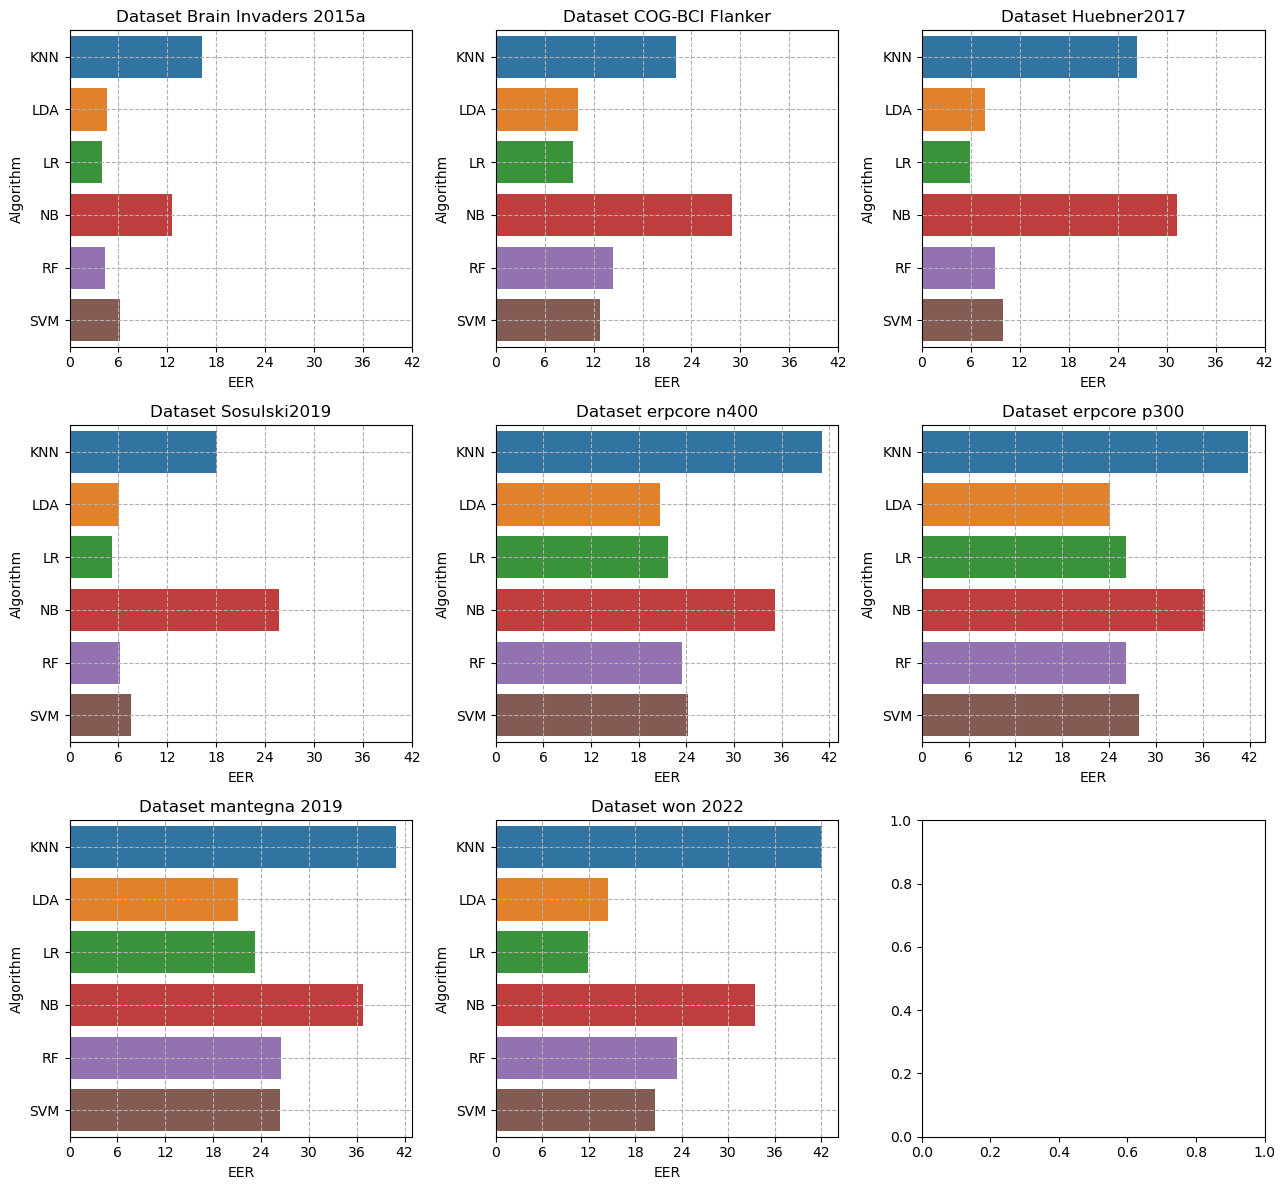

In [19]:
grouped_df_PSD['eer'] = grouped_df_PSD['eer'].astype('float64')

# Get unique datasets
datasets = grouped_df_PSD.dataset.unique()

# Calculate number of rows and columns for subplots
rows = 3
columns = 3

# Create subplots
fig, axs = plt.subplots(rows, columns, figsize=(13, 12))

# Flatten the 2D array of subplots for easy iteration
axs = axs.flatten()

# Create an empty list to store legend handles and labels
legend_handles = []

for i, dataset in enumerate(datasets):
    db = grouped_df_PSD[grouped_df_PSD.dataset == dataset]
    #print(db)

    # Choose the subplot for the current dataset
    ax = axs[i]

    sns.barplot(x='eer', y='pipeline', data=db, ax=ax)
    
    # Hide legend for each subplot
    #ax.get_legend().remove()

    # Set labels and title
    
    # Set labels and title
    ax.set_xlabel('EER')
    ax.set_ylabel('Algorithm')
    ax.set_title("Dataset " + dataset)

   
    #ax.set_ylim(0, 10)
    #ax.set_yticks(range(0, 11, 1))

    # Set y-axis ticks at intervals of 1
    ax.set_xticks(range(0, int(max(grouped_df_PSD['eer'])) + 1, 6))

    ax.grid(True, ls="--", lw=0.8)

# Create a legend outside the subplots
#fig.legend(legend_handles, set(grouped_df_AR['pipeline']), loc='upper right', bbox_to_anchor=(1.10, 0.98), fontsize=12, prop={'size': 16})
plt.subplots_adjust(right=0.60)  # Adjust layout to make room for the legend

    # Adjust layout
plt.tight_layout()
plt.show()


================================================================================================================

<H1>AR+PSD Features</H1>

================================================================================================================


Under this Experiment, we analyze the effect of AR orders on the performance of our authentication systems across all the datasets. We tested the AR orders from 1 to 10 along with PSD on each AR order. Below Parameters were applied for conducting this experiment

<H3>Datasets</H3>

BrainInvaders15a, ERPCORE: N400, ERPCORE: N400, Mantegna2019, COG-BCI Flanker, Lee2019, Won2022, Huebner2017, Sosulski2019

<H3>Utilized Parameters:</H3>

•   Filtering: Band Pass Filtering (1 to 50 Hz)

•   Epoch Interval: [-0.2, 0.8] 

•   Baseline Correction Applied: Yes

•   Epochs Rejection threshold: No Epochs Rejection

•   Features: AR (order=1,2,3,4,5,6,7,8,9,10), PSD

•   Classifiers: LDA, SVM, KNN, RF, NB, LR

•   Evaluation Type: Single-Session Evaluation

•   Threat Case: Open-Set

### Reading data files

In [21]:
brain_AR_PSD_db=pd.read_csv(os.path.join(brainInvaders_dir, "Both_AR_PSD_Features", 'AR_PSD.csv'))
erpCore_N400_AR_PSD_db=pd.read_csv(os.path.join(ERPCORE_N400_dir, "Both_AR_PSD_Features", 'AR_PSD.csv'))
erpCore_P300_AR_PSD_db=pd.read_csv(os.path.join(ERPCORE_P300_dir, "Both_AR_PSD_Features", 'AR_PSD.csv'))
cogbci_AR_PSD_db=pd.read_csv(os.path.join(COG_BCI_Flanker_dir, "Both_AR_PSD_Features", 'AR_PSD.csv'))
manetgna_AR_PSD_db=pd.read_csv(os.path.join(Mantegna2019_dir, "Both_AR_PSD_Features", 'AR_PSD.csv'))
Huebner_AR_PSD_db=pd.read_csv(os.path.join(Huebner_LLP_dir, "Both_AR_PSD_Features", 'AR_PSD.csv'))
sosulski_AR_PSD_db=pd.read_csv(os.path.join(Sosulski2019_dir, "Both_AR_PSD_Features", 'AR_PSD.csv'))
Won2022_AR_PSD_db=pd.read_csv(os.path.join(Won2022_dir, "Both_AR_PSD_Features", 'AR_PSD.csv'))

In [22]:
df_AR_PSD_features_db=pd.concat([brain_AR_PSD_db, erpCore_N400_AR_PSD_db,
                                    erpCore_P300_AR_PSD_db, cogbci_AR_PSD_db,
                                    manetgna_AR_PSD_db, Huebner_AR_PSD_db, sosulski_AR_PSD_db, Won2022_AR_PSD_db], axis=0)

In [23]:
df_AR_PSD_features_db.drop(columns=['evaluation', 'Unnamed: 0'], inplace=True)
df_AR_PSD_features_db['pipeline'] = df_AR_PSD_features_db['pipeline'].apply(lambda x: x.split('+')[-1])
df_AR_PSD_features_db['dataset'].replace({'Visual Speller LLP': "Huebner2017", 'Spot Pilot P300 dataset':'Sosulski2019'}, inplace=True)

In [25]:
#df_AR_PSD_features_db

### Grouping the results of AR+PSD

In [26]:
grouped_df_AR_PSD=df_AR_PSD_features_db.groupby(['dataset','pipeline', 'AR_PSD_order']).agg({
                'eer': lambda x: f'{np.mean(x)*100:.2f}',
                'frr_1_far': lambda x: f'{np.mean(x)*100:.3f}'
            }).reset_index()
#grouped_df_AR

In [27]:
grouped_df_AR_PSD

,dataset,pipeline,AR_PSD_order,eer,frr_1_far
0,Brain Invaders 2015a,KNN,1,2.35,19.857
1,Brain Invaders 2015a,KNN,2,3.66,22.644
2,Brain Invaders 2015a,KNN,3,6.73,27.637
3,Brain Invaders 2015a,KNN,4,11.40,38.233
4,Brain Invaders 2015a,KNN,5,10.71,36.393
...,...,...,...,...,...
475,won 2022,SVM,6,4.92,19.027
476,won 2022,SVM,7,5.34,20.318
477,won 2022,SVM,8,5.40,20.655
478,won 2022,SVM,9,5.61,22.264


### Visualizing Plots for AR+PSD

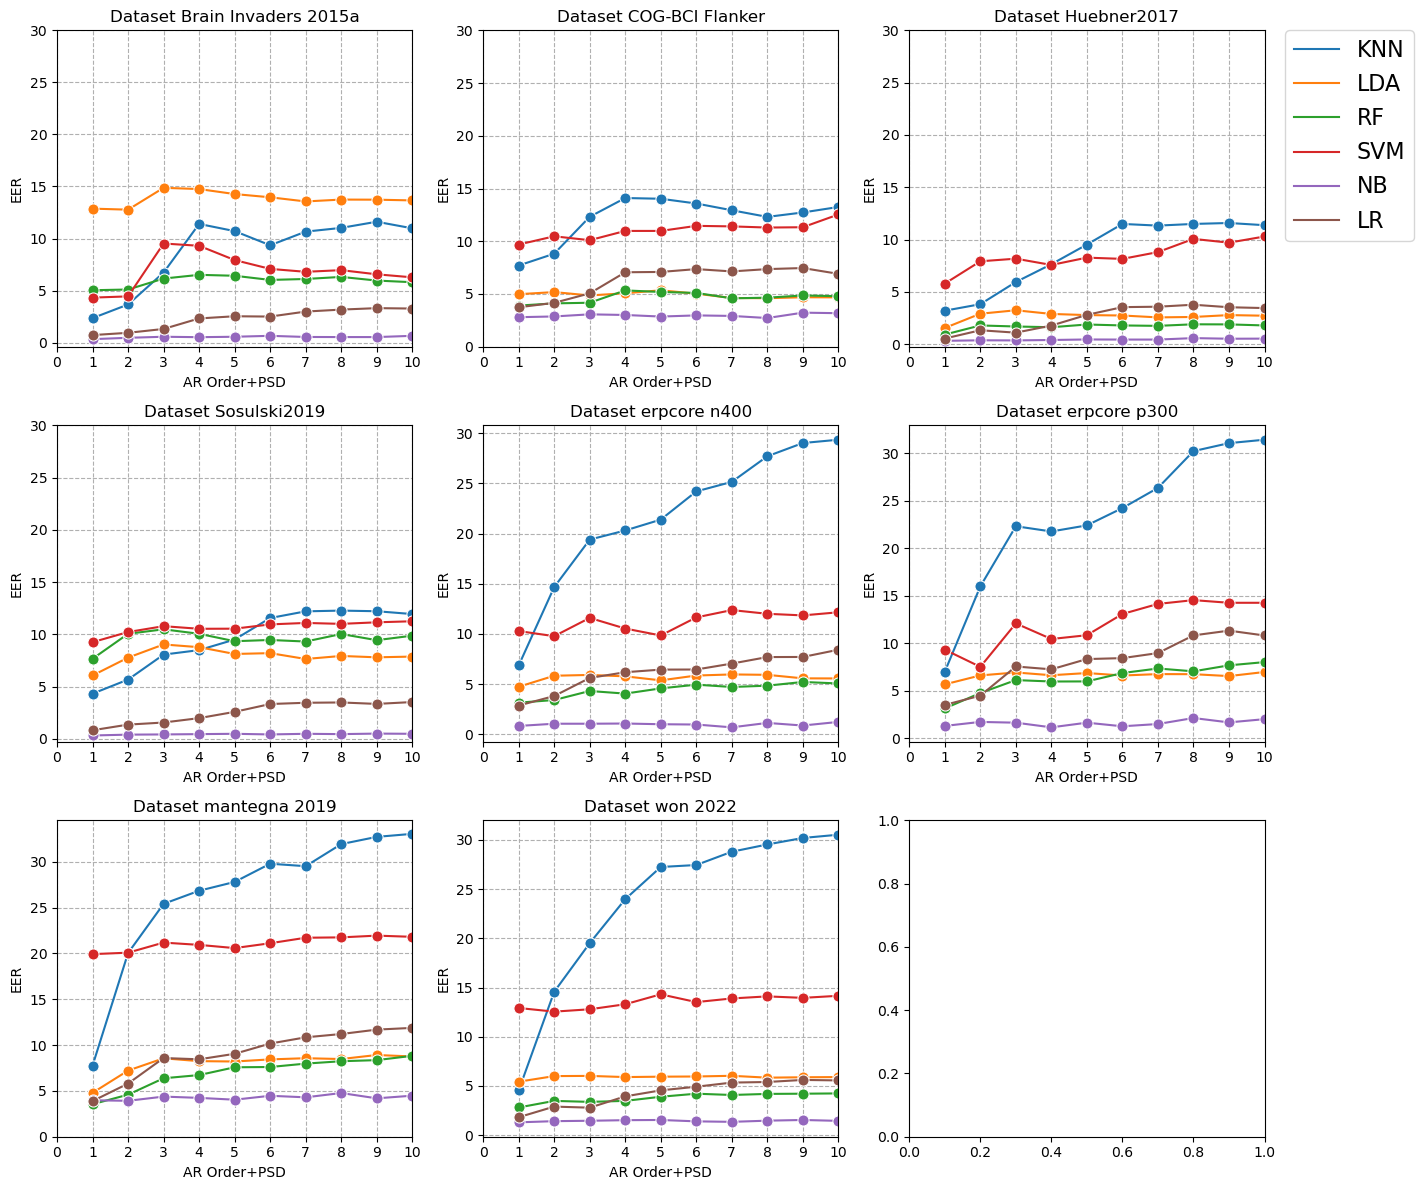

In [30]:
grouped_df_AR_PSD['eer'] = grouped_df_AR_PSD['eer'].astype('float64')

# Get unique datasets
datasets = grouped_df_AR_PSD.dataset.unique()

# Calculate number of rows and columns for subplots
rows = 3
columns = 3

# Create subplots
fig, axs = plt.subplots(rows, columns, figsize=(13, 12))

# Flatten the 2D array of subplots for easy iteration
axs = axs.flatten()

# Create an empty list to store legend handles and labels
legend_handles = []

for i, dataset in enumerate(datasets):
    db = grouped_df_AR_PSD[grouped_df_AR_PSD.dataset == dataset]

    # Choose the subplot for the current dataset
    ax = axs[i]

    sns.lineplot(x='AR_PSD_order', y='eer', hue='pipeline', data=db, marker='o', markersize=8, ax=ax)
    
    # Hide legend for each subplot
    ax.get_legend().remove()

    # Set labels and title
    ax.set_xlabel('AR Order+PSD')
    ax.set_ylabel('EER')
    ax.set_title("Dataset " + dataset)

    # Show legend for the last subplot
    if i == len(datasets) - 1:
        handles, labels = ax.get_legend_handles_labels()
        legend_handles.extend(handles)

    ax.set_xlim(0, 10)
    ax.set_xticks(range(0, 11, 1))

    # Set y-axis ticks at intervals of 1
    ax.set_yticks(range(0, int(max(grouped_df_AR_PSD['eer'])) + 1, 5))

    ax.grid(True, ls="--", lw=0.8)

# Create a legend outside the subplots
fig.legend(legend_handles, set(grouped_df_AR_PSD['pipeline']), loc='upper right', bbox_to_anchor=(1.10, 0.98), fontsize=12, prop={'size': 16})
plt.subplots_adjust(right=0.60)  # Adjust layout to make room for the legend

# Adjust layout
plt.tight_layout()
plt.show()